# Vortex center glow

The aim of this simulation is to model the vortex center glow effect, which is caused to diffraction of the thermal emission from the environment outside the entrance pupil to the pupil image formed on the detector, by the vortex phase mask. 
To model the effect, several points outside the entrance pupil are taken and their intensity on the detector is evaluated. Net effect is determined by adding contributions from all these points.

### Imports

In [1]:
import heeps
from heeps.optics.lens import lens
from heeps.optics.vortex_init import vortex_init
from heeps.util.coord import cart_coord, polar_coord
from heeps.util.img_processing import resize_img, crop_img, pad_img, get_radial_profile
from heeps.optics import lyot_stop, detector, apodizer
from copy import deepcopy
import proper
import numpy as np
np.set_printoptions(threshold=np.inf, linewidth=200)
import os.path
from astropy.io import fits
import astropy.units as u
import matplotlib.pyplot as plt
import multiprocessing as mpro
from functools import partial
from sys import platform
import time
%matplotlib inline

### Input parameters

In [2]:
diam_ext_cold_stop = 40.944
diam_int_cold_stop = 7.363
diam_ext_eff = 37.812
diam_int_eff = 10.196
r_spot = 0.1 # m
ncrop = 101 # for psf visualization
L_flux_env_per_m2 = 1.213e+03 # [photons/s/m2/pix]
L_flux_spi_per_m2 = 1.001e+03 # [photons/s/m2/pix]
L_flux_env = 3.3403e+05 # [photons/s/pix]
L_flux_spi = 0.4478e+05 # [photons/s/pix]
L_flux_std_bkgrd = 3.0747e+05 # [photons/s/pix]
N2_flux_env_per_m2 = 594.8e+03 # [photons/s/m2/pix]
N2_flux_spi_per_m2 = 494.3e+03 # [photons/s/m2/pix]
N2_flux_env = 3.3403e+05 # [photons/s/pix]
N2_flux_spi = 0.4478e+05 # [photons/s/pix]
N2_flux_std_bkgrd = 1.2821e+08 # [photons/s/pix]

### Initialize wavefront using PROPER

In [3]:
conf = dict(
#    dir_current = '/Users/cdelacroix/dox/METIS/METIS_HCI_HEEPS_simulations/VCG',
    band = 'L',
    mode = 'RAVC',
    f_lyot_stop = 'pupil/ls_VCG_293_spi_0.54_RAVC.fits',
    dir_output = 'VCG_RAVC',
    cpu_count = None,
    hfov = 1,
    pupil_img_size = diam_ext_cold_stop + 2*r_spot,
    diam_ext = diam_ext_cold_stop, 
    diam_int = diam_int_cold_stop,
    )
conf = heeps.config.read_config(verbose=False, **conf)
conf = heeps.config.update_config(saveconf=True, verbose=True, **conf)
dir_current = conf['dir_current']
dir_output = conf['dir_output']
npupil = conf['npupil']
ngrid = conf['ngrid']
diam_ext = conf['diam_ext']
pupil_img_size = conf['pupil_img_size']
lam = conf['lam']
pscale = conf['pscale']
spi_width = conf['spi_width']
ndet = conf['ndet']
cpu_count = conf['cpu_count']
beam_ratio = npupil/ngrid*(diam_ext/pupil_img_size)
wf = proper.prop_begin(diam_ext, lam, ngrid, beam_ratio)

if False:
    conf_ls_mask = dict(conf, diam_ext=36.905, diam_int=11.213, f_lyot_stop='', ls_dRext=0.0477, ls_dRint=0.04, ls_dRspi=0.0249)
    ls_mask = lyot_stop(wf, apply_ls=False, **conf_ls_mask)
    start = int(ngrid/2 - npupil/2) + 1
    end = int(ngrid/2 + npupil/2) + 1
    ls_mask = ls_mask[start:end, start:end]
    fits.writeto('ls_VCG_293_spi_0.54_RAVC.fits', ls_mask, overwrite=True)

Simulation config: band=L, mode=RAVC
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
   loading vortex back-propagation params
   vc_charge=2, ngrid=1024, diam_norm=1.0049, beam_ratio=0.2847
   ravc_calc=False, ravc_t=0.7909, ravc_r=0.5190
   npupil=293, pscale=5.4700 mas, lam=3.8133E-06 m
   hfov=1.0 arcsec (-> ndet=365, 51.97 lam/D)



### Create cold stop

(293, 293)


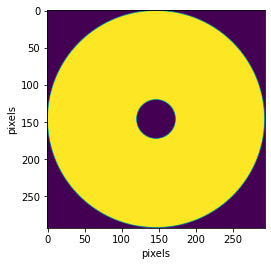

In [4]:
conf_stop = dict(conf, spi_width=0, seg_width=0, diam_ext = diam_ext_cold_stop, diam_int = diam_int_cold_stop)
cold_stop = heeps.pupil.create_pupil(**conf_stop)
print(cold_stop.shape)
plt.imshow(cold_stop), plt.xlabel('pixels'), plt.ylabel('pixels');
cold_stop = pad_img(cold_stop, ngrid)

### Create a spot, normalized by square meter of surface

In [5]:
def create_spot(rad, theta, nimg=10526):
    x, y = cart_coord(nimg)
    x *= pupil_img_size/2
    y *= pupil_img_size/2
    c = (rad*np.cos(np.deg2rad(theta)), rad*np.sin(np.deg2rad(theta)))
    r =  np.abs((x-c[0]) + 1j*(y-c[1]))
    spot = (r <= r_spot)                    # create a spot
    spot = resize_img(spot, npupil)         # resize to npupil
    spot = pad_img(spot, ngrid)             # pad with zeros
    # normalize the entrance pupil intensity (total flux = 1/spot_area)
    I_spot = spot**2
    spot_area = np.pi*r_spot**2
    spot = np.sqrt(I_spot/spot_area)
    return spot

### Generate points along spider edges

In [6]:
def points_along_spi_edge(rads, thetas):
    shift = spi_width/2 - r_spot
    r_spi_shift = []
    t_spi_left = []
    t_spi_right = []
    for rad in rads:
        for theta in thetas:
            r = np.sqrt(rad**2 + shift**2)
            t_l = theta + np.degrees(np.arctan(shift/rad))
            t_r = theta - np.degrees(np.arctan(shift/rad))
            r_spi_shift.append(r)
            t_spi_left.append(t_l)
            t_spi_right.append(t_r)
    r_spi_lr = r_spi_shift + r_spi_shift
    t_spi_lr = t_spi_left + t_spi_right
    return r_spi_lr, t_spi_lr

def points_along_spi_left_edge(rads, thetas):
    shift = spi_width/2 - r_spot
    r_spi_shift = []
    t_spi_left = []
    for rad in rads:
        for theta in thetas:
            r = np.sqrt(rad**2 + shift**2)
            t_l = theta + np.degrees(np.arctan(shift/rad))
            r_spi_shift.append(r)
            t_spi_left.append(t_l)
    return r_spi_shift, t_spi_left

def points_along_spi_right_edge(rads, thetas):
    shift = spi_width/2 - r_spot
    r_spi_shift = []
    t_spi_right = []
    for rad in rads:
        for theta in thetas:
            r = np.sqrt(rad**2 + shift**2)
            t_r = theta - np.degrees(np.arctan(shift/rad))
            r_spi_shift.append(r)
            t_spi_right.append(t_r)
    return r_spi_shift, t_spi_right

### Propagate functions

In [7]:
def fp_mask(wf, rad, mode='RAVC', focal=660, vc_zoffset=1e-3/2, verbose=False, **conf):
        if verbose is True:
            print('   apply vortex phase mask')                        
        # update conf
        conf.update(focal=focal)
        # propagate to vortex
        lens(wf, focal, offset_after=vc_zoffset)
        # load vortex calibration files: psf_num, vvc, perf_num
        conf = vortex_init(verbose=verbose, **conf)
        # get maximum aplitude 
        amp_array = proper.prop_get_amplitude(wf)
        amp_max = np.amax(amp_array)
        #rescale flux
        if rad in r_int:
            proper.prop_multiply(wf, np.sqrt(L_flux_env_per_m2)/amp_max)
        elif rad in r_ext:
            proper.prop_multiply(wf, np.sqrt(L_flux_env_per_m2)/amp_max)
        elif rad in r_spi_lr:
            proper.prop_multiply(wf, np.sqrt(L_flux_spi_per_m2)/amp_max)
        # apply vortex
        scale_psf = wf._wfarr[0,0]/conf['psf_num'][0,0]
        wf_corr = (conf['psf_num']*conf['vvc'] - conf['perf_num'])*scale_psf
        wf._wfarr = wf._wfarr*conf['vvc'] - wf_corr
        # propagate to lyot stop
        lens(wf, focal, offset_before=-vc_zoffset)
        return wf

In [8]:
def propag_one_spot(rad, theta, verbose=False):
        #print(rad, theta)
        # keep a copy of the input wavefront
        wf1 = deepcopy(wf)
        # create a normalized spot
        spot = create_spot(rad, theta)
        # add spot to wavefront
        proper.prop_multiply(wf1, spot)
        # apply cold stop
        proper.prop_multiply(wf1, cold_stop)
        # propagate one frame of onaxis psf (i.e. star)
        wf1 = fp_mask(wf1, rad, verbose=verbose, **conf)
        wf1 = lyot_stop(wf1, verbose=verbose, **conf)
        psf = detector(wf1, verbose=verbose, **conf)
        return psf

In [9]:
def propag_multi_spots(rads, thetas, filename, cpu_count=cpu_count, verbose=False):
    nrads = len(rads)
    nthetas = len(thetas)
    print('radii = %s'%rads)
#    print('angles = %s'%thetas)
    if not os.path.isfile(filename):
        filename = os.path.join(dir_output, filename)
    try:
        cube = fits.getdata(filename)
        print('   Load cube from %s'%filename)
    except FileNotFoundError: # run simulation  
        cube = []
        t0 = time.time()
        if cpu_count != 1 and platform in ['linux', 'linux2', 'darwin']:
            if cpu_count == None:
                cpu_count = mpro.cpu_count() - 1
            print('   %s: VCG simulation starts, using %s cores'\
                %(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()), cpu_count))
            p = mpro.Pool(cpu_count)
            func = partial(propag_one_spot, verbose=verbose)
            if rads in r_int:
                cube = np.array(p.starmap(func, zip(np.repeat(rads, nthetas), np.tile(thetas, nrads))))
            elif rads in r_ext:
                cube = np.array(p.starmap(func, zip(np.repeat(rads, nthetas), np.tile(thetas, nrads))))
            elif rads in r_spi:
                spi_rads, spi_thetas =  points_along_spi_right_edge(rads, thetas)
                cube = np.array(p.starmap(func, zip(spi_rads, spi_thetas)))
            p.close()
            p.join()
        else:
            print('   %s: VCG simulation starts, using 1 core'\
                %(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())))
            for rad in all_rads and theta in all_thetas:
                cube.append(propag_one_spot(rad, theta, verbose=verbose))
        print('   %s: finished, elapsed %.3f seconds'\
            %(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()), time.time() - t0))
        fits.writeto(os.path.join(dir_output, filename), np.float32(cube), overwrite=True)
    return np.array(cube)

### Throughput 

In [10]:
wf_pup = heeps.pupil.pupil(savefits=True, verbose=True, **conf)
if conf['mode'] == 'RAVC':
    wf_pup = apodizer(wf_pup, verbose=True, **conf)
psf = heeps.wavefront.propagate_one(deepcopy(wf_pup), onaxis=False, savefits=True, verbose=True, **conf)
thruput = np.sum(psf)
print('lyot_stop_throughput =', thruput)

Entrance pupil: loaded from 'ELT_fullM1.fits'
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
   apply ring apodizer: ravc_t=0.7909, ravc_r=0.519, apo_misalign=None
Create single off-axis PSF
   apply ring apodizer: ravc_t=0.7909, ravc_r=0.519, apo_misalign=None
   apply lyot stop from 'ls_VCG_293_spi_0.54_RAVC.fits'
   extract PSF on the detector: ndet=365
lyot_stop_throughput = 0.22255596432889657


### VCG from points inside central obscuration

In [11]:
print('range = [%s, %s]'%(diam_int_eff/2, diam_int_cold_stop/2))
r_int = np.arange(diam_int_eff/2 - r_spot, diam_int_cold_stop/2 - r_spot, -2*r_spot)
t_int = np.arange(0,360,10)
cube = propag_multi_spots(r_int, t_int, 'cube_int.fits')

range = [5.098, 3.6815]
radii = [4.998 4.798 4.598 4.398 4.198 3.998 3.798 3.598]
   2023-03-10 00:47:40: VCG simulation starts, using 55 cores
   2023-03-10 00:52:50: finished, elapsed 309.196 seconds


I_int = 3.08E+06 photons/s
I_int_avg = 2.31E+01 photons/s/pix


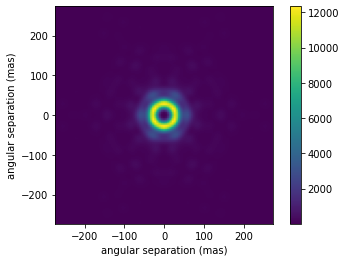

In [12]:
# normalize psf
psf_r_int = []
for i,r in enumerate(r_int):
    psf_r_int.append(np.sum(x*4*np.pi*r*r_spot/len(t_int) for x in cube[i*len(t_int):(i+1)*len(t_int)]))
I_r_int = np.sum((psf_r_int), (1,2))
psf_int = np.sum(psf_r_int, 0)
fits.writeto(os.path.join(dir_output, 'psf_int.fits'), np.float32(psf_int), overwrite=True)
rad_int = get_radial_profile(psf_int, (int(ndet/2), int(ndet/2)), 1)
I_int = np.sum(psf_int)
pix_tot = np.shape(psf_int)[0]*np.shape(psf_int)[1]
print('I_int = %s photons/s'%"{:.2E}".format(I_int))
print('I_int_avg = %s photons/s/pix'%"{:.2E}".format(float(I_int/pix_tot)))
lim = int(ncrop/2)*pscale
plt.imshow(crop_img(psf_int, ncrop), origin='lower', extent=[-lim, lim, -lim, lim])
plt.xlabel('angular separation (mas)'), plt.ylabel('angular separation (mas)'), plt.colorbar();

### VCG from points beyond ELT pupil's outer edge

In [13]:
print('range = [%s, %s]'%(diam_ext_eff/2, diam_ext_cold_stop/2))
r_ext = np.arange(diam_ext_eff/2 + r_spot, diam_ext_cold_stop/2 + r_spot, 2*r_spot)
t_ext = np.arange(0, 360, 5)
cube = propag_multi_spots(r_ext, t_ext, 'cube_ext.fits')

range = [18.906, 20.472]
radii = [19.006 19.206 19.406 19.606 19.806 20.006 20.206 20.406]
   2023-03-10 00:52:52: VCG simulation starts, using 55 cores
   2023-03-10 01:03:14: finished, elapsed 621.764 seconds


I_ext = 9.66E+07 photons/s
I_ext_avg = 7.25E+02 photons/s/pix


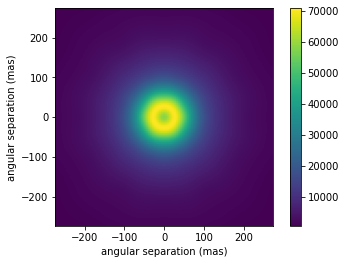

In [14]:
# normalize psf
psf_r_ext = []
for i,r in enumerate(r_ext):
    psf_r_ext.append(np.sum(x*4*np.pi*r*r_spot/len(t_ext) for x in cube[i*len(t_ext):(i+1)*len(t_ext)]))
I_r_ext = np.sum((psf_r_ext), (1,2))
psf_ext = np.sum(psf_r_ext, 0)
fits.writeto(os.path.join(dir_output, 'psf_ext.fits'), np.float32(psf_ext), overwrite=True)
rad_ext = get_radial_profile(psf_ext, (int(ndet/2), int(ndet/2)), 1)
I_ext = np.sum(psf_ext)
pix_tot = np.shape(psf_ext)[0]*np.shape(psf_ext)[1]
print('I_ext = %s photons/s'%"{:.2E}".format(I_ext))
print('I_ext_avg = %s photons/s/pix'%"{:.2E}".format(float(I_ext/pix_tot)))
plt.imshow(crop_img(psf_ext, ncrop), origin='lower', extent=[-lim, lim, -lim, lim])
plt.xlabel('angular separation (mas)'), plt.ylabel('angular separation (mas)'), plt.colorbar();

### VCG from points along spiders

In [15]:
print('range = [%s, %s]'%(diam_int_eff/2, diam_ext_eff/2))
r_spi = np.arange(diam_int_eff/2 + r_spot, diam_ext_eff/2 - r_spot, 2*r_spot)
t_spi = np.arange(30,360,60)
r_spi_lr, t_spi_lr = points_along_spi_right_edge(r_spi, t_spi)
cube = propag_multi_spots(r_spi, t_spi, 'cube_spi.fits')

range = [5.098, 18.906]
radii = [ 5.198  5.398  5.598  5.798  5.998  6.198  6.398  6.598  6.798  6.998  7.198  7.398  7.598  7.798  7.998  8.198  8.398  8.598  8.798  8.998  9.198  9.398  9.598  9.798  9.998 10.198 10.398 10.598
 10.798 10.998 11.198 11.398 11.598 11.798 11.998 12.198 12.398 12.598 12.798 12.998 13.198 13.398 13.598 13.798 13.998 14.198 14.398 14.598 14.798 14.998 15.198 15.398 15.598 15.798 15.998 16.198
 16.398 16.598 16.798 16.998 17.198 17.398 17.598 17.798 17.998 18.198 18.398 18.598 18.798]
   2023-03-10 01:03:17: VCG simulation starts, using 55 cores
   2023-03-10 01:10:41: finished, elapsed 444.402 seconds


I_spi = 1.38E+08 photons/s
I_spi_avg = 1.03E+03 photons/s/pix


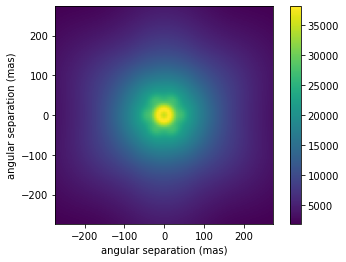

In [16]:
# normalize psf
psf_r_spi = []
for i,r in enumerate(r_spi):
    psf_r_spi.append(np.sum(x*2*spi_width*r_spot for x in cube[i*len(t_spi):(i+1)*len(t_spi)]))
I_r_spi = np.sum((psf_r_spi), (1,2))
psf_spi = np.sum(psf_r_spi, 0)
fits.writeto(os.path.join(dir_output, 'psf_spi.fits'), np.float32(psf_spi), overwrite=True)
rad_spi = get_radial_profile(psf_spi, (int(ndet/2), int(ndet/2)), 1)
I_spi = np.sum(psf_spi)
pix_tot = np.shape(psf_spi)[0]*np.shape(psf_spi)[1]
print('I_spi = %s photons/s'%"{:.2E}".format(I_spi))
print('I_spi_avg = %s photons/s/pix'%"{:.2E}".format(float(I_spi/pix_tot)))
lim = int(ncrop/2)*pscale
plt.imshow(crop_img(psf_spi, ncrop), origin='lower', extent=[-lim, lim, -lim, lim])
plt.xlabel('angular separation (mas)'), plt.ylabel('angular separation (mas)'), plt.colorbar();

### Total VCG from all sources: int + ext + spi

I_all = 2.37E+08 photons/s
I_max_pix = 1.15E+05 photons/s/pix
I_avg = 1.78E+03 photons/s/pix


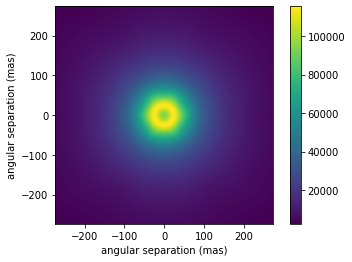

In [17]:
psf_all = psf_int + psf_ext + psf_spi
fits.writeto(os.path.join(dir_output, 'psf_all.fits'), np.float32(psf_all), overwrite=True)
rad_all = get_radial_profile(psf_all, (int(ndet/2), int(ndet/2)), 1)
I_all = np.sum(psf_all)
I_max_pix = np.amax(psf_all)
pix_tot = np.shape(psf_all)[0] * np.shape(psf_all)[1]
print('I_all = %s photons/s'%"{:.2E}".format(I_all))
print('I_max_pix = %s photons/s/pix'%"{:.2E}".format(I_max_pix))
print('I_avg = %s photons/s/pix'%"{:.2E}".format(float(I_all/pix_tot)))
plt.imshow(crop_img(psf_all, ncrop), origin='lower', extent=[-lim, lim, -lim, lim])
plt.xlabel('angular separation (mas)'), plt.ylabel('angular separation (mas)'), plt.colorbar();

### Radial profile

5.1253546993486285
34866.29542727595
28533900.18660783
0.5095230320817771


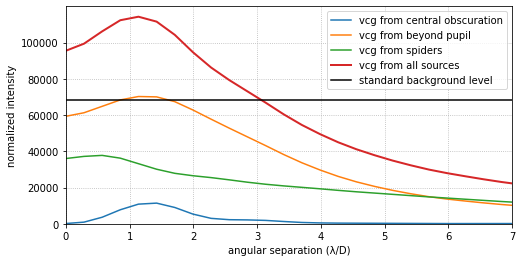

In [18]:
x = np.arange(rad_all.shape[0])*pscale*u.mas.to('rad')/(lam/diam_ext)
print(x[18])
print(rad_all[18])
print(N2_flux_std_bkgrd*thruput)
print(rad_all[18]/(L_flux_std_bkgrd*thruput))
plt.figure(figsize=(8,4))
plt.plot(x, rad_int, label='vcg from central obscuration')
plt.plot(x, rad_ext, label='vcg from beyond pupil')
plt.plot(x, rad_spi, label='vcg from spiders')
plt.plot(x, rad_all, label='vcg from all sources', linewidth=2)
plt.axhline(y=L_flux_std_bkgrd*thruput, color = 'k', label='standard background level')
plt.xlabel('angular separation (λ/D)'), 
plt.ylabel('normalized intensity')
plt.xlim(0, 7)
plt.ylim(bottom=0), plt.legend()
plt.grid(True, linestyle=':')
plt.savefig(os.path.join(dir_output, 'vcg_radial_profile.png'), dpi=300, transparent=True);

### Distribution of spots

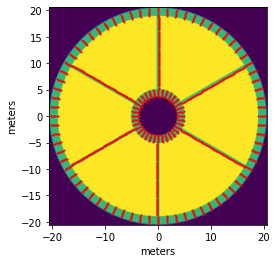

In [19]:
conf_pup = dict(conf, seg_width=0, diam_ext=diam_ext_eff, diam_int=diam_int_eff)
pup = heeps.pupil.create_pupil(**conf_pup)
lim = pupil_img_size/2
plt.imshow(crop_img(cold_stop, 293) + pup/2, origin='lower', extent=[-lim, lim, -lim, lim])
rs = np.concatenate((np.repeat(r_int, len(t_int)), np.repeat(r_ext, len(t_ext)), r_spi_lr))
ts = np.concatenate((np.tile(t_int, len(r_int)), np.tile(t_ext, len(r_ext)), t_spi_lr))
xs = rs * np.cos(np.deg2rad(ts))
ys = rs * np.sin(np.deg2rad(ts))
plt.scatter(xs, ys, 1, color='r'), plt.xlabel('meters'), plt.ylabel('meters');
#fig_size = plt.gcf().get_size_inches() 
#sizefactor = 2 
#plt.gcf().set_size_inches(sizefactor*fig_size)

### contribution of spots as a function of their radial distance in the pupil

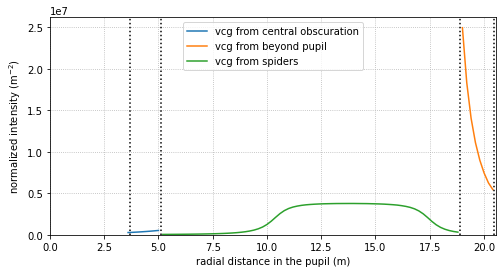

In [20]:
plt.figure(figsize=(8,4))
plt.plot(r_int, I_r_int, label='vcg from central obscuration')
plt.plot(r_ext, I_r_ext, label='vcg from beyond pupil')
plt.plot(r_spi, I_r_spi, label='vcg from spiders')
plt.axvline(diam_int_cold_stop/2, color='k', linestyle=':')
plt.axvline(diam_int_eff/2, color='k', linestyle=':')
plt.axvline(diam_ext_cold_stop/2, color='k', linestyle=':')
plt.axvline(diam_ext_eff/2, color='k', linestyle=':')
plt.xlabel('radial distance in the pupil (m)'), plt.ylabel('normalized intensity (m$^{-2})$')
plt.xlim(0, pupil_img_size/2), plt.ylim(bottom=0), plt.legend()
plt.grid(True, linestyle=':')
plt.savefig(os.path.join(dir_output, 'vcg_radial_contributions.png'), dpi=300, transparent=True);

## Results

In [ ]:
#Roy's input
flux_env = 3.34E+05 photons/s/pix
flux_spi = 4.48E+04 photons/s/pix

In [ ]:
#L-band
I_int = 2.94E+07 photons/s
I_ext = 1.12E+08 photons/s
I_spi = 1.56E+08 photons/s
I_all = 2.97E+08 photons/s
I_env_avg = 1.06E+03 photons/s/pix
I_spi_avg = 1.17E+03 photons/s/pix
I_max_pix = 1.59E+05 photons/s/pix
I_avg = 2.23E+03 photons/s/pix
I_all_5lam-D = 50007.714918870195

#N2-band
I_int = 6.18E+10 photons/s
I_ext = 2.32E+11 photons/s
I_spi = 2.60E+11 photons/s
I_all = 5.54E+11 photons/s
I_ext_avg = 3.37E+06 photons/s/pix
I_spi_avg = 2.99E+06 photons/s/pix
I_max_pix = 7.16E+07 photons/s/pix
I_avg = 6.36E+06 photons/s/pix
I_all_5lam-D = 57985635.29193979

## Flux scaling

#### 1. Entracnce pupil plane  

   1.1 Create a spot with radius 10 cm 
   
    I_spot --> [photons/s/pix]  
       
   1.2 Scale it by area  
   
    I_spot --> [photons/s/pix/m2]  
    
#### 2. CFO-FP2

   2.1 Rescale the flux to Roy's input, before passing through the VPM  
   
    I_spot_max --> flux_env or flux_spi [photons/s/pix/m2]

#### 3. Detector plane

   3.1 Intensity of spot in detector plane  
   
    I_spot --> [photons/s/pix/m2]  
    
   3.2 Normalize and sum contributions of all spots in a particular region  
   
    I_region --> [photons/s/pix]
       